In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return mins, maxs

def rescale_data(data, channel_min, channel_max):
    return 255 * (data - channel_min) / (channel_max - channel_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    mins, maxs = find_min_max_across_channels(ds_combined)

    rescaled_data_list = [xr.apply_ufunc(
        rescale_data,
        ds_combined[i],
        kwargs={'channel_min': mins[i], 'channel_max': maxs[i]},
        vectorize=True
    ) for i in range(ds_combined.shape[0])]

    rescaled_data = xr.concat(rescaled_data_list, dim='channels')

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    for label in [cloud_labels, clear_labels, ice_labels]:
        assert ds_combined.coords == label.coords, 'Mismatch between data coordinates and label coordinates'

    cloud_labels_clean = cloud_labels.values.flatten()
    clear_labels_clean = clear_labels.values.flatten()
    ice_labels_clean = ice_labels.values.flatten()

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_clean) & \
                         ~np.isnan(clear_labels_clean) & \
                         ~np.isnan(ice_labels_clean)

    combined_labels_clean = get_combined_labels(cloud_labels_clean, clear_labels_clean, ice_labels_clean)
    combined_labels_clean_filtered = combined_labels_clean[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')
    
    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel5/')

/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       642037       597159       501159
Actual 1         4071         4969         5303
Actual 2         2770         2935          996
Accuracy - Combined Labels: 0.3678905233851047




ValueError: 'c' argument has 1800000 elements, which is inconsistent with 'x' and 'y' with size 1778598.

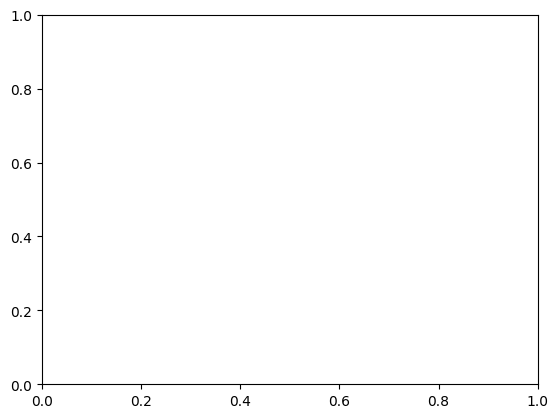

In [8]:
import matplotlib.pyplot as plt

# Loop through each channel and plot its points with color-coded clusters
for i in range(rescaled_array_clean.shape[1]):
    plt.scatter(rescaled_array_clean[:, i], rescaled_array_clean[:, (i+1)%rescaled_array_clean.shape[1]], 
                c=cluster_labels_clean, cmap='viridis', alpha=0.5, label=f'Channel {i+1}')

# Set labels and title
plt.xlabel('Feature in Channel i')
plt.ylabel('Feature in Channel i+1')
plt.title('Clustering Overlay on Channels')

plt.colorbar()
plt.legend()

plt.show()


In [9]:
print("Length of rescaled_array_clean:", len(rescaled_array_clean))
print("Length of cluster_labels_clean:", len(cluster_labels_clean))


Length of rescaled_array_clean: 1778598
Length of cluster_labels_clean: 1200


In [12]:
import pandas as pd
from pandas.plotting import parallel_coordinates

# Create a DataFrame with the rescaled data and cluster labels
df = pd.DataFrame(rescaled_array_clean, columns=[f'Channel {i+1}' for i in range(rescaled_array_clean.shape[1])])
df['Cluster Labels'] = cluster_labels_clean

# Create a parallel coordinates plot
plt.figure(figsize=(10,6))
parallel_coordinates(df, 'Cluster Labels', colormap='viridis', alpha=0.5)

plt.xlabel('Channels')
plt.ylabel('Feature Value')
plt.title('Parallel Coordinates Plot with Clustering Overlay')

plt.show()


ValueError: Length of values (1200) does not match length of index (1778598)

In [13]:
print("Length of cluster_labels_clean:", len(cluster_labels_clean))
print("Length of DataFrame index:", len(df))


Length of cluster_labels_clean: 1200
Length of DataFrame index: 1778598


In [15]:
# Randomly sample 10,000 points 
sample_indices = np.random.choice(rescaled_array_clean.shape[0], size=10000, replace=False)
sample_data = rescaled_array_clean[sample_indices, :]

# Get cluster labels
sample_labels = cluster_labels_clean[sample_indices]

# Create a scatter plot with color-coded clusters
plt.scatter(sample_data[:, 0], sample_data[:, 1], c=sample_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()


IndexError: index 1064886 is out of bounds for axis 0 with size 1200

In [16]:
print(min(sample_indices), max(sample_indices))
print(cluster_labels_clean.shape)


201 1778528
(1200, 1500)


ValueError: 'c' argument has 1800000 elements, which is inconsistent with 'x' and 'y' with size 1778598.

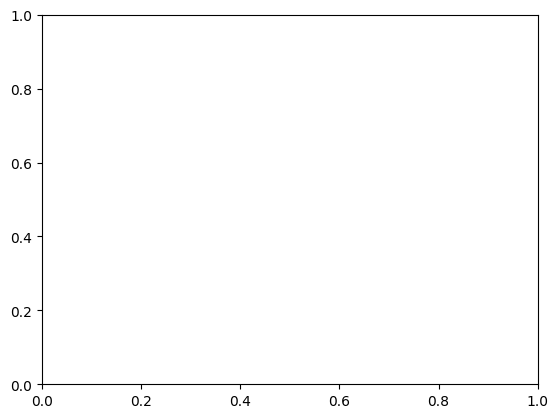

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(rescaled_array_clean)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_clean, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering in Reduced Dimension')
plt.colorbar()
plt.show()


In [18]:
print(pca_result.shape)
print(cluster_labels_clean.shape)


(1778598, 2)
(1200, 1500)


In [ ]:
from sklearn.manifold import TSNE

# Create t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit the model
tsne_result = tsne.fit_transform(rescaled_array_clean)

# Create a scatter plot with color-coded clusters
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels_clean, cmap='viridis', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')

plt.show()
